# Overlay Nation Shapefile

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, box, LineString

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r

Read files

In [2]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'

fn_coords = '/Volumes/Extreme SSD/largest_plots/clean_data/coords.parquet'  # used for QC

fn_nation_shape = '/Volumes/Extreme SSD/largest_plots/raw_data/cb_2021_us_all_5m/cb_2021_us_nation_5m.zip'
fn_nation_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/nation_overlay.parquet'

In [3]:
Aoi = gpd.read_parquet(fn_aoi)
NationShape = gpd.read_file(fn_nation_shape).to_crs(epsg=target_epsg)
NationShape.head()

,AFFGEOID,GEOID,NAME,geometry
0,0100000US,US,United States,"MULTIPOLYGON (((-5215608.250 5698763.159, -521..."


In [4]:
# For QC only
Coords = gpd.read_parquet(fn_coords).to_crs(epsg=target_epsg)[['geometry']]
Coords.head()

,geometry
0,POINT (1014783.733 1201341.503)
1,POINT (1203970.757 1196193.050)
2,POINT (1230030.297 1370238.314)
3,POINT (1602992.164 1520284.428)
4,POINT (1467647.954 1434669.498)


Overlay the national boundary on the areas of interest

In [5]:
NationOverlay = gpd.overlay(Aoi, NationShape, how='intersection')[['geometry']]

# Optional QC

In [6]:
color_dict = {True:'firebrick', False:'darkorange'}
is_full_area = np.round(NationOverlay.area) == (100*1e3)*(100*1e3)
is_full_area = is_full_area.tolist()
color_list = [color_dict[value] for value in is_full_area]

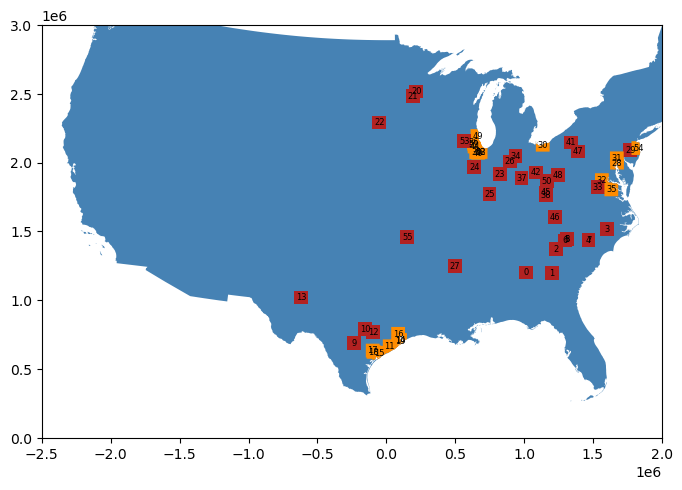

In [106]:
fig, ax = plt.subplots(figsize=(8, 15))
xlim = (-0.25*1e7,  0.2*1e7)
ylim = (0,  3*1e6)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

NationShape.plot(ax=ax, color='steelblue')
NationOverlay.plot(ax=ax, color=color_list)

for x, y, label in zip(Coords.geometry.x, Coords.geometry.y, Coords.index.tolist()):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center', va='center')
    
plt.show()

Here, we can peek at a single overlap, to make sure it worked right.

In [7]:
# indices with overlap
np.where( np.round(NationOverlay.area) != (100*1e3)*(100*1e3) )

(array([11, 14, 15, 16, 17, 18, 19, 28, 30, 31, 32, 35, 36, 39, 40, 43, 44,
        49, 51, 52, 54]),)

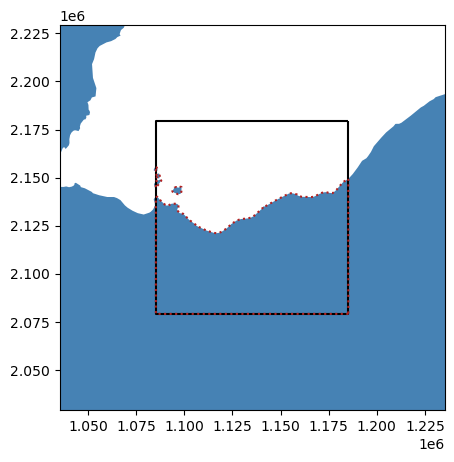

In [8]:
i = 30  # index to look at
minx, miny, maxx, maxy = Aoi.loc[i, 'aoi'].buffer(distance=50*1e3, cap_style='square').bounds
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
NationShape.plot(ax=ax, color = 'steelblue')
Aoi.loc[[i]].boundary.plot(ax=ax, color = 'black')
NationOverlay.loc[[i]].boundary.plot(ax=ax, color = 'firebrick', linestyle='dotted')
plt.show()

In [9]:
Coords.shape[0] == NationOverlay.shape[0]

True

# Write to disk

In [10]:
NationOverlay.to_parquet(fn_nation_overlay)